In [73]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import json
from datetime import datetime, timedelta
from tqdm import tqdm
from arch import arch_model

In [74]:
def fetch_tpex_stock_data(stock_code, date):
    url = "https://www.tpex.org.tw/www/zh-tw/afterTrading/tradingStock"
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36"
    }
    payload = {
        "code": stock_code,
        "date": date,
        "id": "",
        "response": "json"
    }
    res = requests.post(url, headers=headers, data=payload)
    data = json.loads(res.text)

    rows = data["tables"][0]["data"]
    columns = data["tables"][0]["fields"]

    df = pd.DataFrame(rows, columns=columns)

    df[["開盤", "最高", "最低", "收盤"]] = df[["開盤", "最高", "最低", "收盤"]].apply(pd.to_numeric, errors='coerce')
    df = df[["日 期", "開盤", "最高", "最低", "收盤", "成交仟股"]]
    df.rename(columns={
        "日 期": "Date",
        "開盤": "Open",
        "最高": "High",
        "最低": "Low",
        "收盤": "Close",
        "成交仟股": "Volume"
    }, inplace=True)
    df = df.replace(',', '', regex=True)
    df["Date"] = df["Date"].apply(convert_minguo_to_ad)
    df["Date"] = pd.to_datetime(df["Date"], format="%Y/%m/%d")

    return df

def fetch_twse_monthly_data(stock_id, year, month, fallback_to_tpex = True):
    def convert_minguo_to_ad(date_str):
        parts = date_str.split('/')
        year = int(parts[0]) + 1911
        return f"{year}/{parts[1]}/{parts[2]}"
    
    url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY"
    params = {
        "response": "json",
        "date": f"{year}{month:02}01",
        "stockNo": stock_id
    }

    r = requests.get(url, params = params)
    r.encoding = 'utf-8-sig'
    data = r.json()

    if data['stat'] != 'OK':
        if fallback_to_tpex:
            date = f"{year}/{month:02}/01"
            return fetch_tpex_stock_data(stock_id, date)
        return None

    df = pd.DataFrame(data['data'], columns = data['fields'])

    df['Date'] = df['日期'].apply(convert_minguo_to_ad)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
    df.drop(columns=['日期'], inplace=True)
    df = df.rename(columns={
        '日期': 'Date',
        '開盤價': 'Open',
        '最高價': 'High',
        '最低價': 'Low',
        '收盤價': 'Close',
        '成交股數': 'Volume'
    })
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df = df.replace(',', '', regex = True)
    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric, errors='coerce')

    return df


def get_tw_stock_by_twse(stock_id, start_date, end_date):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    all_data = []
    current = start.replace(day = 1)

    while current <= end:
        df = fetch_twse_monthly_data(stock_id, current.year, current.month)
        if df is not None:
            df['Date'] = pd.to_datetime(df['Date']) 
            df = df[(df['Date'] >= start) & (df['Date'] <= end)]
            all_data.append(df)
        current += timedelta(days=32)
        current = current.replace(day=1)

    result = pd.concat(all_data).sort_values('Date').set_index('Date')
    return result

In [75]:
security1 = '0050'
security2 = '00631L'
end_date = datetime.now()
start_date = end_date - timedelta(days = 365)

df1 = get_tw_stock_by_twse(security1, '2024-01-01', '2025-04-30')
df2 = get_tw_stock_by_twse(security2, '2024-01-01', '2025-04-30')

prices = pd.concat([df1['Close'], df2['Close']], axis = 1)
prices.columns = [security1, security2]

In [76]:
def calculate_statistics(prices):
    returns = prices.pct_change().dropna()
    
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    std_devs = returns.std()
    correlation = returns[security1].corr(returns[security2])
    return mean_returns, cov_matrix, std_devs, correlation

In [77]:
def simulate_portfolio(prices, initial_weights, initial_capital, cost, mean_returns, cov_matrix, num_days, rebalance_threshold):
    # 生成模擬的價格路徑
    price_simulate = pd.DataFrame(index = range(num_days + 1), columns = prices.columns)
    price_simulate.iloc[0] = prices.iloc[-1]

    holdings = initial_capital * np.array(initial_weights) / price_simulate.iloc[0]
    portfolio_value = [initial_capital]
    rebalance_count = 0

    for t in range(num_days):
        # 生成相關的隨機報酬
        rand_returns = np.random.multivariate_normal(mean_returns, cov_matrix)
        daily_returns = pd.Series(rand_returns, index = prices.columns)

        price_simulate.iloc[t + 1] = price_simulate.iloc[t] * (1 + daily_returns)

        # 計算當前權重
        current_portfolio_value = np.sum(holdings * price_simulate.iloc[t])
        current_weights = (holdings * price_simulate.iloc[t]) / current_portfolio_value

        # 檢查是否需要再平衡
        num_assets = len(initial_weights)
        for i in range(num_assets):
            if abs(current_weights.iloc[i] - initial_weights[i]) > rebalance_threshold:
                # 再平衡的過程
                target_portfolio_value = portfolio_value[-1]
                target_holdings = target_portfolio_value * np.array(initial_weights) / price_simulate.iloc[t + 1]
                
                trade_amount = np.abs(target_holdings - holdings) * price_simulate.iloc[t + 1]
                transaction_cost = trade_amount.sum() * cost
                portfolio_value[-1] -= transaction_cost

                holdings = target_holdings
                rebalance_count += 1
                break

        portfolio_value.append(np.sum(holdings * price_simulate.iloc[t + 1]))

    return pd.Series(portfolio_value, index = price_simulate.index), rebalance_count

In [78]:
def calculate_weights(leverage_ratio, leverage_factors: list):
    # leverage_factors 為每個標的真實槓桿倍數
    f1, f2 = leverage_factors

    w1 = (f2 - leverage_ratio) / (f2 - f1)
    w2 = (leverage_ratio - f1) / (f2 - f1)

    return [w1, w2]

In [81]:
def evaluate_threshold(leverage_ratio, leverage_factors: list, cost, threshold, num_simulations = 5000, num_days = 252, initial_capital = 100000):
    final_values = []
    total_rebalances = 0
    initial_weights = calculate_weights(leverage_ratio, leverage_factors)
    mean_returns, cov_matrix, _, _ = calculate_statistics(prices)

    for _ in tqdm(range(num_simulations)):
        portfolio_simulate, rebalances = simulate_portfolio(prices, initial_weights, initial_capital, cost, mean_returns, cov_matrix, num_days, threshold)
        final_values.append(portfolio_simulate.iloc[-1])
        total_rebalances += rebalances

    avg_final_value = np.mean(final_values)
    avg_rebalances = total_rebalances / num_simulations

    return avg_final_value, avg_rebalances

100%|██████████| 5000/5000 [06:46<00:00, 12.29it/s]


start_date: 2024-05-22 18:21:22.144852
 end_date: 2025-05-22 18:21:22.144852
平均報酬率:
0050      0.000865
00631L    0.000972
dtype: float64
共變異數矩陣:
            0050    00631L
0050    0.000317  0.000577
00631L  0.000577  0.001110
標準差:
0050      0.017802
00631L    0.033321
dtype: float64
相關係數:
0.972878146336195
      avg_final_value  avg_rebalances
0.01    123969.616726         18.9032
0.02    124972.349881          5.8784
0.03    125511.816529          2.7560
0.04    125774.694708          1.5312
0.05    124788.359133          0.9444
0.06    124887.549771          0.6186
0.07    125053.990645          0.4070
0.08    124496.045440          0.2642
0.09    125534.925973          0.1758
0.10    125440.631462          0.1108


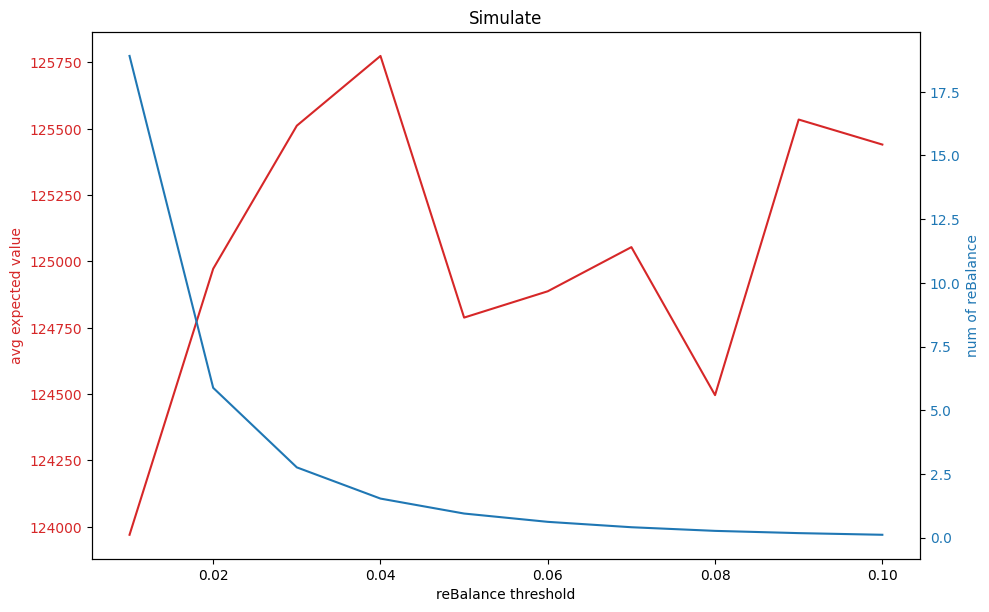


根據平均最終價值，最佳再平衡閾值為: 0.04


In [ ]:
thresholds_to_test = np.arange(0.01, 0.11, 0.01) # 測試 1% 到 10% 的閾值
leverage_factors = [1, 2]  # 0050 是1倍槓桿，0050正2是2倍槓桿
leverage_ratio = 1.3
cost = 0.00357 # 單邊手續費 0.000285, 證交稅 0.003, 總共 0.00207
results = {}

for threshold in thresholds_to_test:
    avg_final_value, avg_rebalances = evaluate_threshold(leverage_ratio, leverage_factors, cost, threshold)
    results[threshold] = {'avg_final_value': avg_final_value, 'avg_rebalances': avg_rebalances}

df_results = pd.DataFrame.from_dict(results, orient = 'index')
mean_returns, cov_matrix, std_devs, correlation = calculate_statistics(prices)
print(f"start_date: {start_date}\n end_date: {end_date}")
print(f"平均報酬率:\n{mean_returns}\n共變異數矩陣:\n{cov_matrix}\n標準差:\n{std_devs}\n相關係數:\n{correlation}")
print(df_results)

fig, ax1 = plt.subplots(figsize = (10, 6))

color = 'tab:red'
ax1.set_xlabel('reBalance threshold')
ax1.set_ylabel('avg expected value', color = color)
ax1.plot(df_results.index, df_results['avg_final_value'], color=color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('num of reBalance', color = color)
ax2.plot(df_results.index, df_results['avg_rebalances'], color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

fig.tight_layout()
plt.title('Simulate')
plt.show()

best_threshold = df_results['avg_final_value'].idxmax()
print(f"\n根據平均最終價值，最佳再平衡閾值為: {best_threshold:.2f}")